# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [2]:
import tensorflow as tf
from scipy.io import loadmat

import numpy as np
import matplotlib.pyplot as plt

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [3]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Load the dataset from Drive folder

train = loadmat("gdrive/My Drive/Colab Notebooks/TensorFlow2/course 1/week 5/data/train_32x32.mat")
test = loadmat("gdrive/My Drive/Colab Notebooks/TensorFlow2/course 1/week 5/data/test_32x32.mat")

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [5]:
#extract training and testing data + normalizing:

x_train = train['X']
x_train = np.moveaxis(x_train, -1, 0) / 255
y_train = train['y']

x_test = test['X']
x_test = np.moveaxis(x_test, -1, 0) / 255
y_test = test['y']

#correcting labels: 10 -> 0
y_train = np.where(y_train == 10, 0, y_train)
y_test = np.where(y_test == 10, 0, y_test)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (73257, 32, 32, 3)
y_train shape: (73257, 1)
x_test shape: (26032, 32, 32, 3)
y_test shape: (26032, 1)


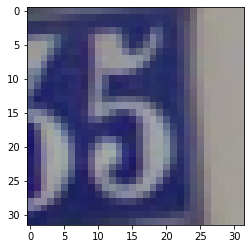

Label: [5]


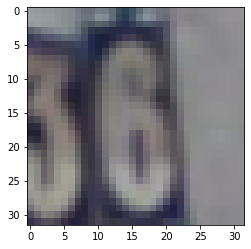

Label: [6]


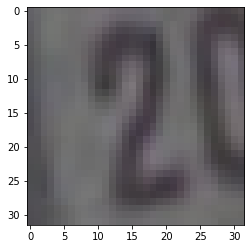

Label: [2]


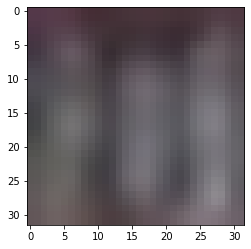

Label: [0]


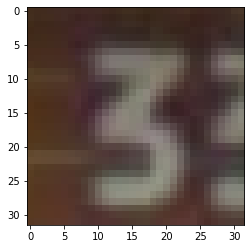

Label: [3]


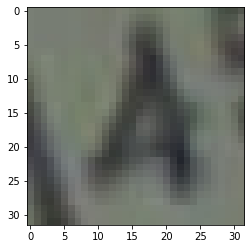

Label: [4]


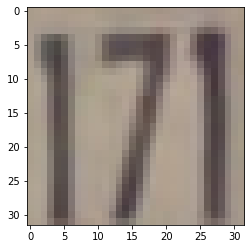

Label: [7]


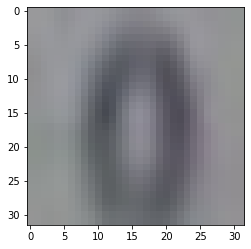

Label: [0]


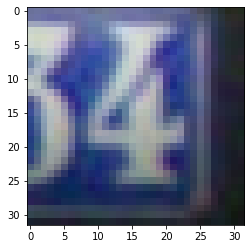

Label: [4]


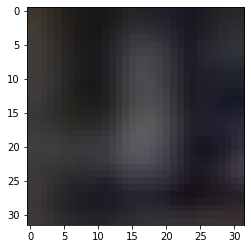

Label: [1]


In [6]:
#display 10 random images and their labels from the dataset

for i in range(10):
  rand_idx = np.random.choice(x_train.shape[0])
  img = x_train[rand_idx]
  plt.imshow(img)
  plt.show()
  print(f"Label: {y_train [rand_idx]}")

In [7]:
#convert to gray scale:

x_train_gscaled = np.average(x_train,axis = -1)
x_test_gscaled = np.average(x_test,axis = -1)

#adding a dummy dimention:
x_train_gscaled = x_train_gscaled[..., np.newaxis]
x_test_gscaled = x_test_gscaled[..., np.newaxis]

print(f"x_train_gscaled shape: {x_train_gscaled.shape}")
print(f"x_test_gscaled shape: {x_test_gscaled.shape}")

x_train_gscaled shape: (73257, 32, 32, 1)
x_test_gscaled shape: (26032, 32, 32, 1)


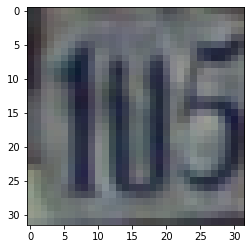

Label: [0]


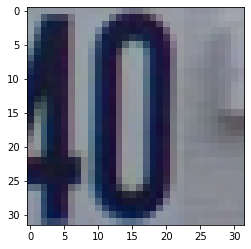

Label: [0]


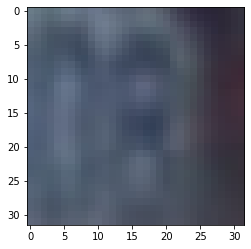

Label: [8]


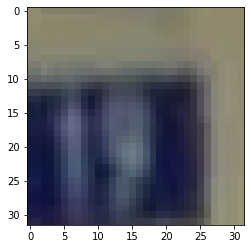

Label: [9]


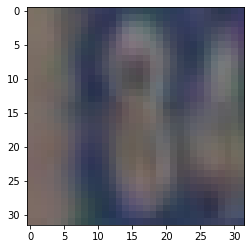

Label: [8]


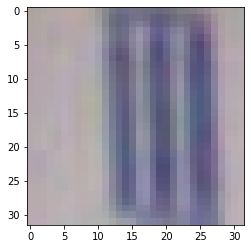

Label: [1]


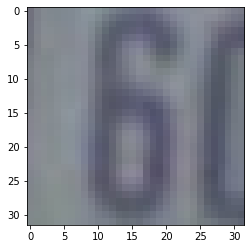

Label: [6]


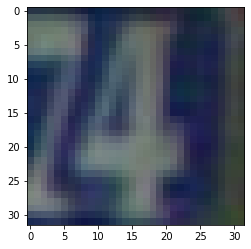

Label: [4]


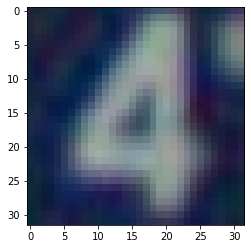

Label: [4]


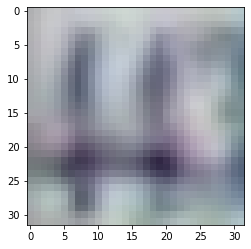

Label: [4]


In [8]:
#display 10 random images and their labels from the gscaled dataset

for i in range(10):
  rand_idx = np.random.choice(x_train_gscaled.shape[0])
  img = x_train[rand_idx]
  plt.imshow(img, cmap="gray", vmin=0, vmax= 1)
  plt.show()
  print(f"Label: {y_train[rand_idx]}")

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [9]:
#imports for model:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

In [10]:
#building the MLP model function:

def get_model(input_shape, wd):
  #input_shape - the shape of our img
  #wd - weight decay parameter for l2 regularization

  model = Sequential([
                      Flatten(input_shape = input_shape), #flattening the img
                      Dense(1024, kernel_regularizer= regularizers.l2(wd), activation='relu'),
                      Dense(512, kernel_regularizer= regularizers.l2(wd), activation='relu'),
                      Dense(512, kernel_regularizer= regularizers.l2(wd), activation='relu'),
                      Dense(10, activation='softmax')
  ])

  return model

In [11]:
#defining the input shape:
input_shape = x_train_gscaled[0].shape

In [12]:
#create the model & print summary:
model = get_model(input_shape,1e-5)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 1,842,186
Trainable params: 1,842,186
Non-trainable params: 0
_________________________________________________________________


In [13]:
#compiling the model:
model.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
#imports for callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [15]:
#creating callbacks for training:

def get_checkpoint_best_only(path):
  #path - the path for where to save model weightss
  checkpoint = ModelCheckpoint(filepath = path, save_weights_only = True, save_best_only = True, save_freq = 'epoch', 
                                  monitor = 'val_accuracy', verbose = 1)
  return checkpoint

def get_earlystop():
  #monitoring the validation set accuracy
  early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 3, mode = 'max')
  return early_stop


In [16]:
#getting the callbacks:
checkpoint = get_checkpoint_best_only("gdrive/My Drive/Colab Notebooks/TensorFlow2/course 1/week 5/checkpoint/best model")
early_stop = get_earlystop()

In [17]:
#training:
history = model.fit(x = x_train_gscaled, y = y_train, batch_size=64 , epochs= 30, validation_data=(x_test_gscaled, y_test), callbacks= [checkpoint, early_stop])

Epoch 1/30
1145/1145 [==============================] - ETA: 0s - loss: 1.8973 - accuracy: 0.3293
Epoch 00001: val_accuracy improved from -inf to 0.47008, saving model to gdrive/My Drive/Colab Notebooks/TensorFlow2/course 1/week 5/checkpoint/best model
1145/1145 [==============================] - 38s 33ms/step - loss: 1.8973 - accuracy: 0.3293 - val_loss: 1.5887 - val_accuracy: 0.4701
Epoch 2/30
1144/1145 [============================>.] - ETA: 0s - loss: 1.3471 - accuracy: 0.5579
Epoch 00002: val_accuracy improved from 0.47008 to 0.59965, saving model to gdrive/My Drive/Colab Notebooks/TensorFlow2/course 1/week 5/checkpoint/best model
1145/1145 [==============================] - 37s 32ms/step - loss: 1.3470 - accuracy: 0.5580 - val_loss: 1.2770 - val_accuracy: 0.5996
Epoch 3/30
1145/1145 [==============================] - ETA: 0s - loss: 1.1494 - accuracy: 0.6342
Epoch 00003: val_accuracy improved from 0.59965 to 0.63975, saving model to gdrive/My Drive/Colab Notebooks/TensorFlow2/cou

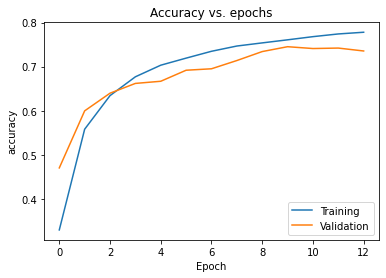

In [18]:
#plot accuracy vs epoch:

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

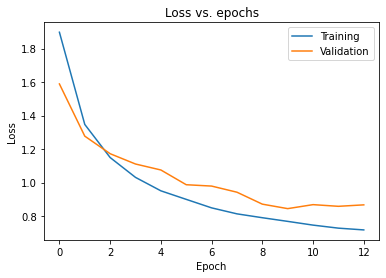

In [19]:
#plot loss vs epoch:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [20]:
#evaluating the trained model:
def evaluate_model(model, scaled_test_images, test_labels):
    test_loss, test_accuracy = model.evaluate(scaled_test_images,test_labels, verbose=2)
    return (test_loss, test_accuracy)

In [21]:
#displaying test loss and accuracy:

test_loss, test_accuracy = evaluate_model(model, x_test_gscaled, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

814/814 - 6s - loss: 0.8669 - accuracy: 0.7356
Test loss: 0.8669062256813049
Test accuracy: 0.735594630241394


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [45]:
#build CNN model:

def get_cnn_model(input_shape, wd, rate):
  model = Sequential([
                      Conv2D(16, (3,3), activation= 'relu', input_shape = input_shape, name = "conv_1"),
                      BatchNormalization(name= 'batch_norm_1'),
                      MaxPooling2D((2, 2), name = "max_pool_1"),
                      Conv2D(32, (3,3), activation= 'relu', input_shape = input_shape, name = "conv_2"),
                      BatchNormalization(name= 'batch_norm_2'),
                      MaxPooling2D((2, 2), name = "max_pool_2"),
                      Flatten(name = "flatten"),
                      Dense(256, activation= 'relu', kernel_regularizer= regularizers.l1(wd), name = "dense_1"),
                      Dropout(rate),
                      Dense(256, activation= 'relu', kernel_regularizer= regularizers.l1(wd), name = "dense_2"),
                      Dropout(rate),
                      Dense(10, activation= 'softmax', name = "dense_3")
  ])

  return model

In [46]:
#create the model & print summary:
model = get_cnn_model(input_shape, 1e-3, 0.15)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        160       
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 30, 30, 16)        64        
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 15, 15, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 13, 13, 32)        4640      
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 13, 13, 32)        128       
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)             

In [47]:
#compiling the model:
model.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
#imports for callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [26]:
#getting the callbacks: (same callbacks as before)
checkpoint = get_checkpoint_best_only("gdrive/My Drive/Colab Notebooks/TensorFlow2/course 1/week 5/checkpoint_cnn/best model")
early_stop = get_earlystop()

In [48]:
#training
history = model.fit(x = x_train_gscaled, y = y_train, batch_size=64 , epochs= 30, validation_data=(x_test_gscaled, y_test), callbacks= [checkpoint, early_stop])

Epoch 1/30
1144/1145 [============================>.] - ETA: 0s - loss: 3.0686 - accuracy: 0.7874
Epoch 00001: val_accuracy did not improve from 0.83985
1145/1145 [==============================] - 75s 66ms/step - loss: 3.0675 - accuracy: 0.7874 - val_loss: 1.2215 - val_accuracy: 0.8071
Epoch 2/30
1144/1145 [============================>.] - ETA: 0s - loss: 1.0539 - accuracy: 0.8406
Epoch 00002: val_accuracy did not improve from 0.83985
1145/1145 [==============================] - 74s 64ms/step - loss: 1.0538 - accuracy: 0.8406 - val_loss: 1.0299 - val_accuracy: 0.8387
Epoch 3/30
1144/1145 [============================>.] - ETA: 0s - loss: 0.9803 - accuracy: 0.8511
Epoch 00003: val_accuracy did not improve from 0.83985
1145/1145 [==============================] - 73s 64ms/step - loss: 0.9802 - accuracy: 0.8511 - val_loss: 1.0570 - val_accuracy: 0.8292
Epoch 4/30
1144/1145 [============================>.] - ETA: 0s - loss: 0.9640 - accuracy: 0.8553
Epoch 00004: val_accuracy improved fro

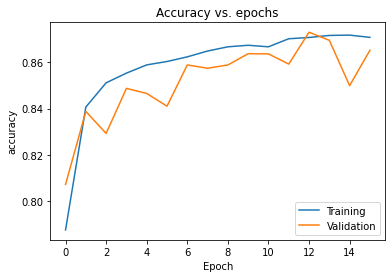

In [49]:
#plot accuracy vs epoch:

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

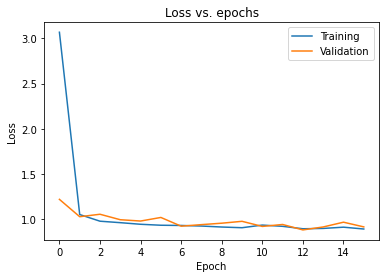

In [50]:
#plot loss vs epoch:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [51]:
#displaying test loss and accuracy: (using same function from mlp)

test_loss, test_accuracy = evaluate_model(model, x_test_gscaled, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

814/814 - 7s - loss: 0.9174 - accuracy: 0.8652
Test loss: 0.9173752665519714
Test accuracy: 0.8652043342590332


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [52]:
#load weights function:

def load_model_weights(model, path):
  model.load_weights(path)

In [54]:
#initialize two new models
mlp_model = get_model(input_shape,1e-3)
cnn_model = get_cnn_model(input_shape,1e-3,0.15)

In [55]:
#load weights:
mlp_model.load_weights("gdrive/My Drive/Colab Notebooks/TensorFlow2/course 1/week 5/checkpoint/best model")
cnn_model.load_weights("gdrive/My Drive/Colab Notebooks/TensorFlow2/course 1/week 5/checkpoint_cnn/best model")

In [56]:
#predict and display function:

def predictions(model, scaled_test_images, test_labels):
  num_test_images = scaled_test_images.shape[0]

  rand_idx = np.random.choice(num_test_images, 5)
  random_test_images = scaled_test_images[rand_idx, ...]
  random_test_labels = test_labels[rand_idx, ...]

  predictions = model.predict(random_test_images)

  fig, axes = plt.subplots(5, 2, figsize=(16, 12))
  fig.subplots_adjust(hspace=0.4, wspace=-0.2)

  for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
      axes[i, 0].imshow(np.squeeze(image))
      axes[i, 0].get_xaxis().set_visible(False)
      axes[i, 0].get_yaxis().set_visible(False)
      axes[i, 0].text(10., -1.5, f'Digit {label}')
      axes[i, 1].bar(np.arange(len(prediction)), prediction)
      axes[i, 1].set_xticks(np.arange(len(prediction)))
      axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
      
  plt.show()

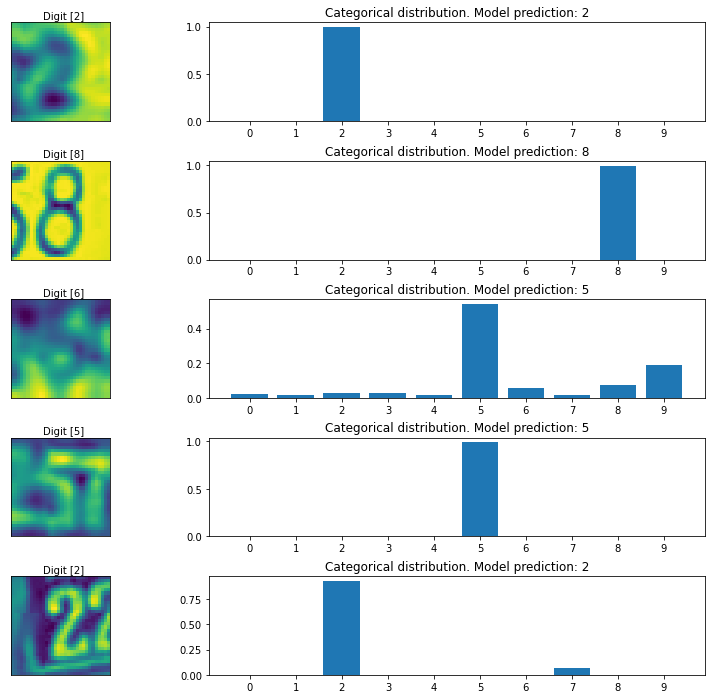

In [61]:
#predicting on mlp model:
predictions(mlp_model, x_test_gscaled, y_test)

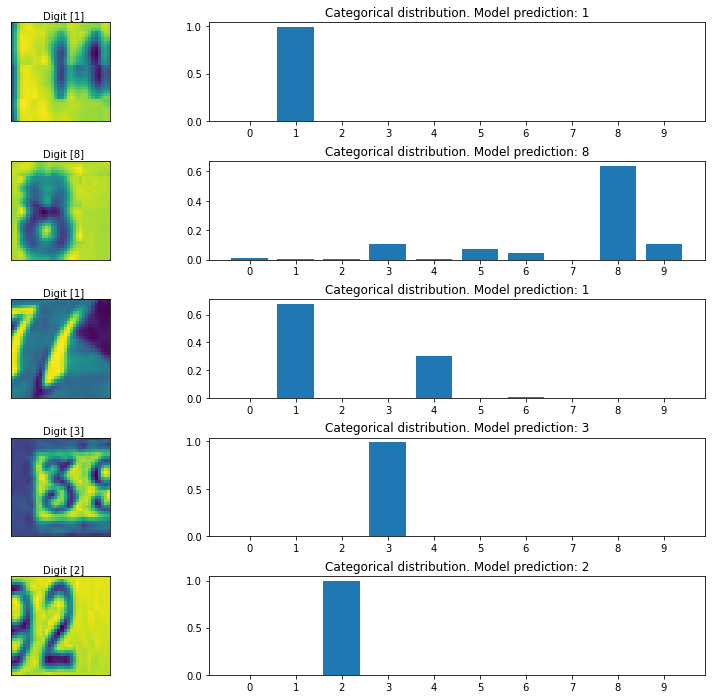

In [59]:
#predicting on cnn model:
predictions(cnn_model, x_test_gscaled, y_test)